In [1]:
import numpy as np
import market_plotting_utils as mpu
import market_simulation_utils as msu
import matplotlib.pyplot as plt

In [2]:
initial_price = 4
u = 2
r = 0.25
K = 5

In [3]:
msu.fair_option_price_multi_period(1,initial_price,u,1/u,r,K)

(1.2000000000000002, {0: array([0.5])})

In [4]:
N = 400
M = 5000
x, ys_rw = msu.symmetric_random_walk_discrete(N,M)

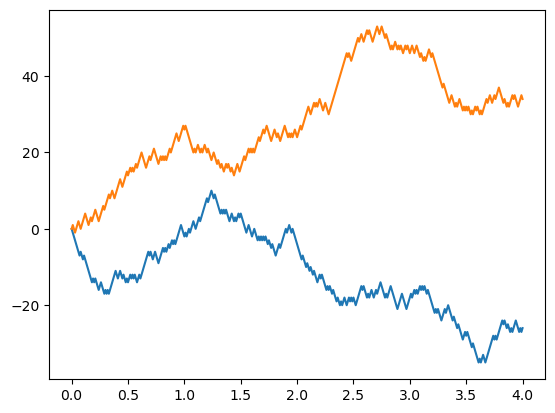

In [5]:
plt.plot(x/100,ys_rw[0],x/100,ys_rw[2])

In [6]:
k = int(1)
ls = np.arange(k+1,N,1,dtype=int)
increment_kls = [msu.path_increment_discrete(int(l),k,ys_rw) for l in ls]

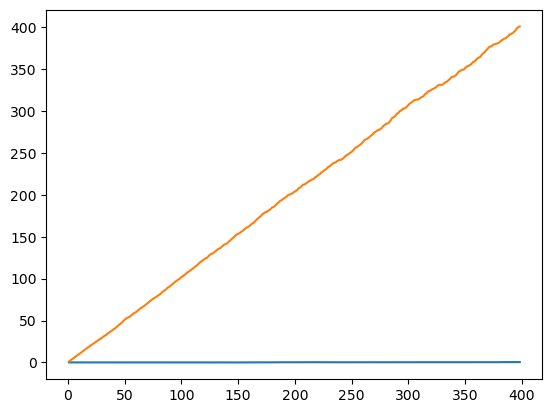

In [7]:
plt.plot(ls-k,increment_kls)

In [8]:
msu.quadratic_variation(2,ys_rw[0])

np.float64(2.0)

In [9]:
x_b,ys_b = msu.approximate_brownian_motion(100,4,M)

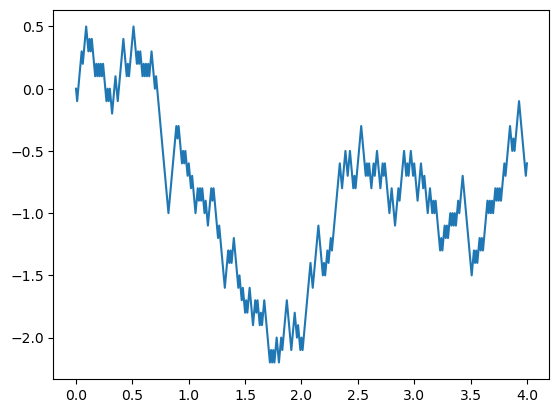

In [10]:
plt.plot(x_b,ys_b[0])

In [11]:
T = 10
steps = 10000
x_bc, ys_bc = msu.continuous_brownian_motion(T,steps,M)

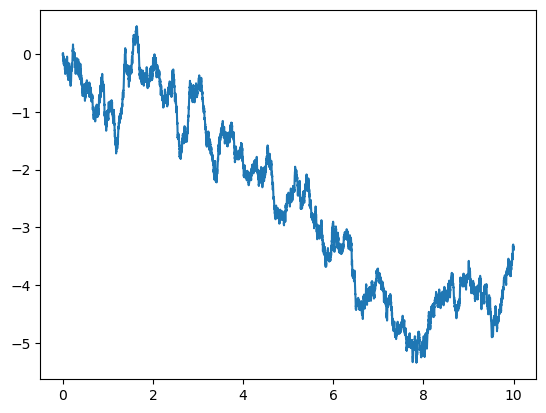

In [12]:
plt.plot(x_bc,ys_bc[1])

In [13]:
x_gbm, ys_gbm = msu.geometric_brownian_motion(100,0.08,0.2,10,400,1000)

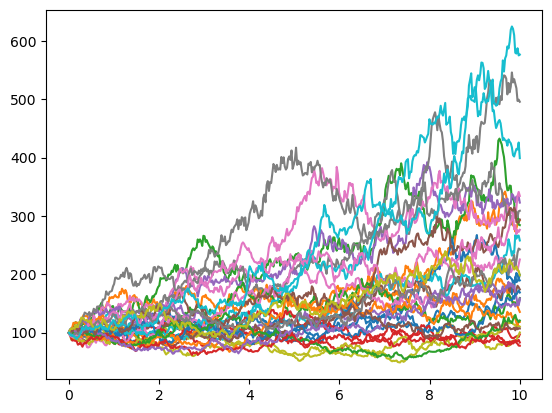

In [14]:
for ys in ys_gbm[10:40]:
    plt.plot(x_gbm,ys)

In [2]:
start,end = '2022-01-01','2025-01-01'
spy_data = msu.fetch_stock_data(start,end,["SPY"])

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:137: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


In [3]:
close_price = spy_data["CLOSE_SPY"]
close_log = spy_data["LOG_RETURN_SPY"].dropna()
years_past = (spy_data.index[-1] - spy_data.index[0]).days / 364.25
initial_price = close_price.iloc[0]
empirical_vol = np.sqrt(252) * close_log.std()
empirical_mean = (1/years_past)*np.log(close_price.iloc[-1]/close_price.iloc[0]) + 0.5*empirical_vol**2
print(f"Empirical Mean (Annual) = {empirical_mean}\nEmpirical Volatility (Annual) = {empirical_vol}")

Empirical Mean (Annual) = 0.09812161243107631
Empirical Volatility (Annual) = 0.17520656035399154


In [4]:
sim_count= 1000
time_steps, predicted_spys, true_spy = msu.gbm_price_sim(start,end,"SPY",sim_count)

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:137: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


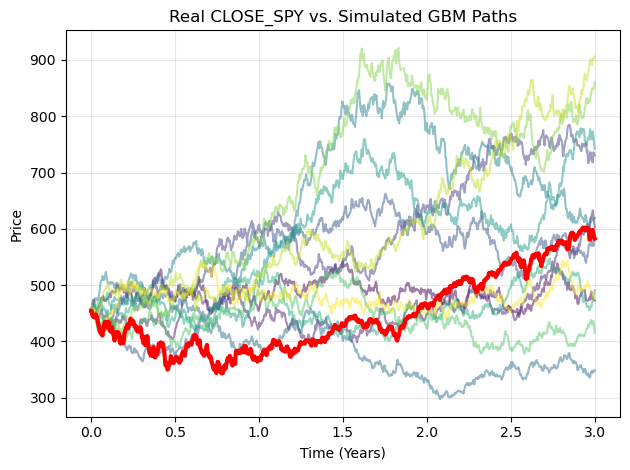

In [5]:
mpu.plot_simulated_close_price(predicted_spys,true_spy,12,False,False)

In [6]:
predicted_spys_log_returns = msu.log_returns_gbm_price_sim(predicted_spys)

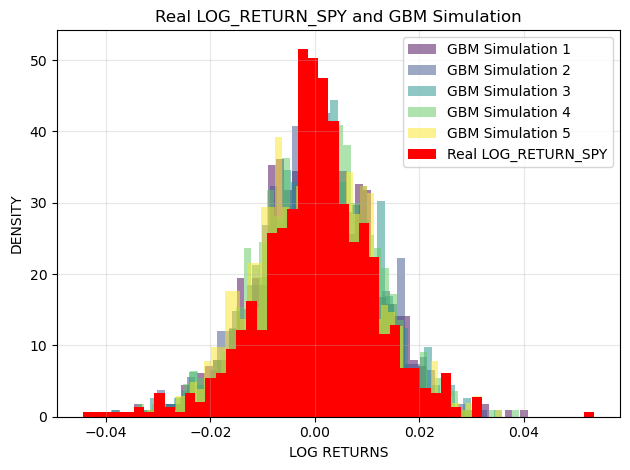

In [7]:
mpu.plot_simulated_log_return(predicted_spys_log_returns,true_spy)

In [ ]:
### Here and below does not work ###
simulated_moments = mbu.moments_df(simulated_df)
real_moments = mbu.moments_df(spy_data)

In [610]:
price_moments_mean = simulated_moments.loc["mean"].iloc[:sim_count]
price_moments_std = simulated_moments.loc["std"].iloc[:sim_count]
price_moments_skew = simulated_moments.loc["skew"].iloc[:sim_count]
price_moments_kurt = simulated_moments.loc["kurt"].iloc[:sim_count]

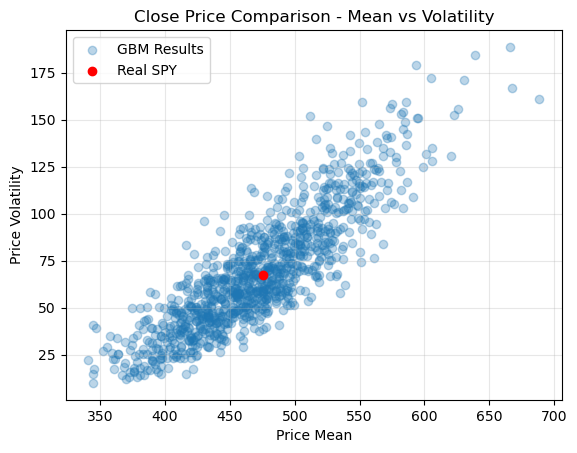

In [617]:
plt.scatter(price_moments_mean,price_moments_std,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["CLOSE_SPY"]["mean"]],[real_moments["CLOSE_SPY"]["std"]],color='red',label='Real SPY')
plt.xlabel('Price Mean')
plt.ylabel('Price Volatility')
plt.title('Close Price Comparison - Mean vs Volatility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

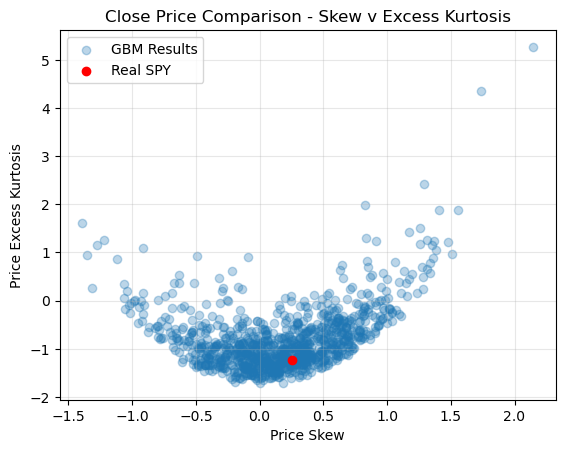

In [624]:
plt.scatter(price_moments_skew,price_moments_kurt,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["CLOSE_SPY"]["skew"]],[real_moments["CLOSE_SPY"]["kurt"]],color='red',label='Real SPY')
plt.xlabel('Price Skew')
plt.ylabel('Price Excess Kurtosis')
plt.title('Close Price Comparison - Skew v Excess Kurtosis')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

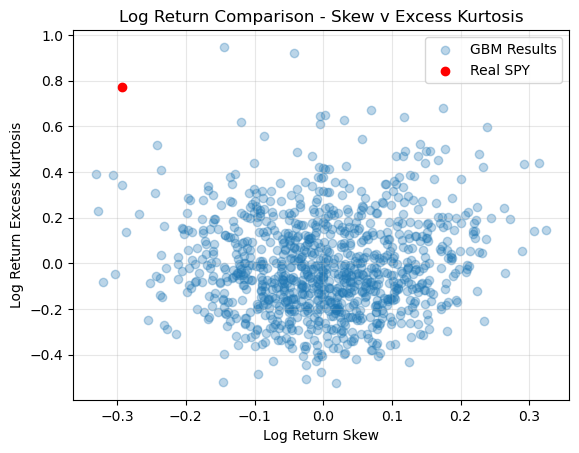

In [623]:
log_moments_mean = simulated_moments.loc["mean"].iloc[sim_count:]
log_moments_std = simulated_moments.loc["std"].iloc[sim_count:]
log_moments_skew = simulated_moments.loc["skew"].iloc[sim_count:]
log_moments_kurt = simulated_moments.loc["kurt"].iloc[sim_count:]

plt.scatter(log_moments_skew,log_moments_kurt,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["LOG_SPY"]["skew"]],[real_moments["LOG_SPY"]["kurt"]],color='red',label='Real SPY')
plt.xlabel('Log Return Skew')
plt.ylabel('Log Return Excess Kurtosis')
plt.title('Log Return Comparison - Skew v Excess Kurtosis')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

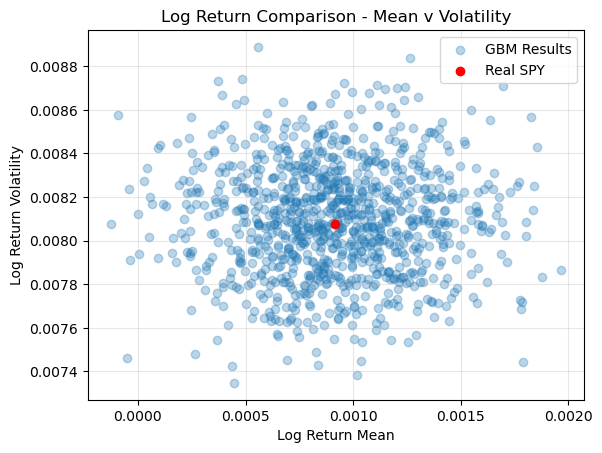

In [ ]:
plt.scatter(log_moments_mean,log_moments_std,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["LOG_SPY"]["mean"]],[real_moments["LOG_SPY"]["std"]],color='red',label='Real SPY')
plt.xlabel('Log Return Mean')
plt.ylabel('Log Return Volatility')
plt.title('Log Return Comparison - Mean v Volatility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

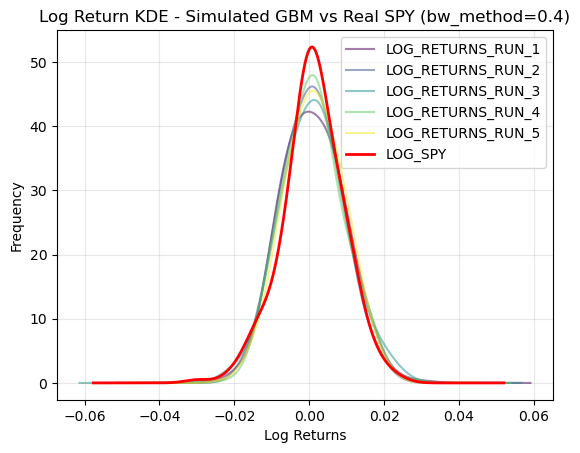

In [668]:
all_data = pd.concat([simulated_df,spy_data],axis=1)
method = 0.4
ax = all_data[[(f"log_returns_run_{i+1}").upper() for i in range(display_count)]].plot.kde(alpha=0.5,color=colors,bw_method=method)
all_data["LOG_SPY"].plot.kde(ax=ax,linewidth=2,alpha=1.0,color='red',label="LOG_SPY",bw_method=method)
plt.title(f"Log Return KDE - Simulated GBM vs Real SPY (bw_method={method})")
plt.ylabel('Frequency')
plt.xlabel('Log Returns')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [674]:
window = "30D"
all_log_data = all_data[[(f"log_returns_run_{i+1}").upper() for i in range(sim_count)]+["LOG_SPY"]]
all_log_rolling = all_log_data.rolling(window=window)

all_rollings = []
for i in range(sim_count+1):
    if i == sim_count:
        key = "LOG_SPY"
    else:
        key = (f"log_returns_run_{i+1}").upper() 
    
    single_rollings = all_log_rolling[key].std()
    all_rollings.append(single_rollings)

cols_to_dict = [s.to_dict() for s in all_rollings]
rolling_vol = pd.DataFrame(cols_to_dict).T
rolling_vol.rename(lambda x: (f"log_returns_run_{x+1}").upper() if x != sim_count else "LOG_SPY" ,axis="columns",inplace=True)

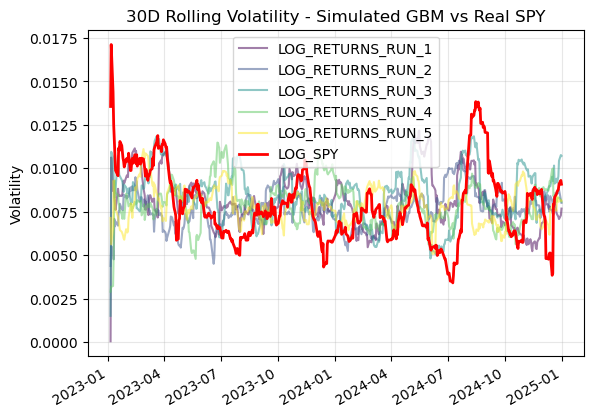

In [675]:
ax = rolling_vol[[(f"log_returns_run_{i+1}").upper() for i in range(display_count)]].plot(alpha=0.5,color=colors)
rolling_vol["LOG_SPY"].plot(ax=ax,linewidth=2,alpha=1.0,color='red',label='LOG_SPY')
plt.title(f'{window} Rolling Volatility - Simulated GBM vs Real SPY')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [2]:
time_steps, simulation_relts = msu.gbm_price_sim('2023-01-01','2025-01-01',"SPY",1000)

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:117: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


In [3]:
true_data = msu.fetch_stock_data('2023-01-01','2025-01-01',["SPY"])["CLOSE_SPY"]

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:117: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


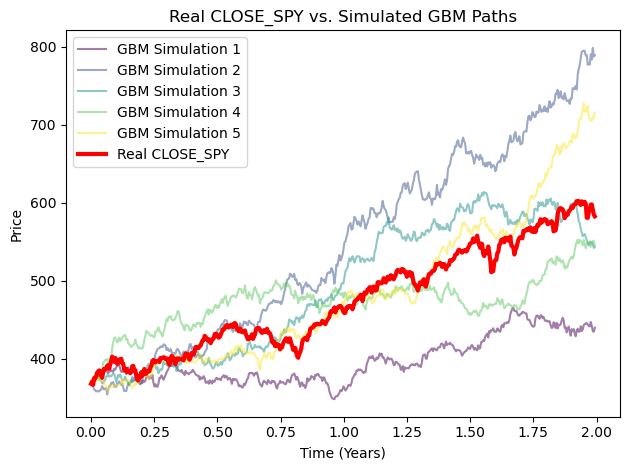

In [ ]:
mpu.plot_simulated_close_price(time_steps,simulation_relts,true_data) 